# Lunar Lander with Q Learning

In this notebook we are going to train an agent to play the Lunar Lander game using tabular methods as:
- Q Learning
- Q Learning with Eligibility Traces
- Q Learning with Eligibility Traces and spatial decay

In [1]:
# General libraries
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

# Deep learning
import torch
from torch import nn

# Video display
from IPython.display import Video
from moviepy import *

# Custom modules
from src.utils import *


# Set seed
SEED = 31
np.random.seed(SEED)
torch.manual_seed(SEED)
print(f"Using seed {SEED}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}")

Using seed 31
Using device cuda


## The Environment

The Lunar Lander environment is a 2D environment where the agent has to land a spaceship on a landing pad.
The agent has 4 actions available:
- Do nothing
- Fire left orientation engine
- Fire main engine
- Fire right orientation engine

The agent receives a reward of 100 for landing on the landing pad and -100 for crashing. The agent also receives a reward proportional to the fuel used to land the spaceship.

The state space is a 8-dimensional vector with the following components:
- x position
- y position
- x velocity
- y velocity
- angle
- angular velocity
- left leg contact
- right leg contact

The environment is considered solved when the agent reaches an average reward of 200 over 100 episodes.

![Lunar Lander](https://www.gymlibrary.dev/_images/lunar_lander.gif)

In [2]:
import gymnasium as gym

env_name = 'LunarLander-v3'
env = gym.make(env_name)

In [3]:
from src.networks import Qnet

n_episodes = 1_000

initial_lr = 1e-3
final_lr = 1e-3
# Compute gamma
gamma = np.exp(np.log(final_lr / initial_lr) / n_episodes)
print(f"Gamma: {gamma:.3f}")

network_params = {
    'input_dim': 8,
    'output_dim': env.action_space.n,
    'hidden_dim': [64, 64],
    'device': device,
    'optimizer_params': {
        'lr': initial_lr,
        'weight_decay': 1e-8,
        'betas': (0.9, 0.999),
    },
    'lr_scheduler_params' : {
        'gamma': gamma,
    },
    'dropout': 0.0,
    'batchnorm': False,
    'activation': nn.ReLU,
}

q_main = Qnet(**network_params)
q_main.init_weights(random=True)    # N(0,1)
q_target = Qnet(**network_params)
q_target.init_weights(random=False) # zeros

Gamma: 1.000


In [4]:
from src.DeepAgents import DQNAgent

agent = DQNAgent(
    env = env,
    discount_factor = 0.99,
    initial_epsilon=1.0,
    epsilon_decay=0.987,
    min_epsilon=0.01,
    learning_rate=0.99,
    q_main=q_main,
    q_target=q_target,
    batch_size=64,
    buffer_size=10_000_000,
    inertia=0.8
)

In [ ]:
n_episodes = 200
rewards, losses, steps = agent.learn(n_episodes, 500, 100)
rewards = pd.Series(rewards)
losses = pd.Series(losses)

Simulating:   0%|          | 0/300 [00:00<?, ?it/s]

Plot the rewards obtained by the agent during training

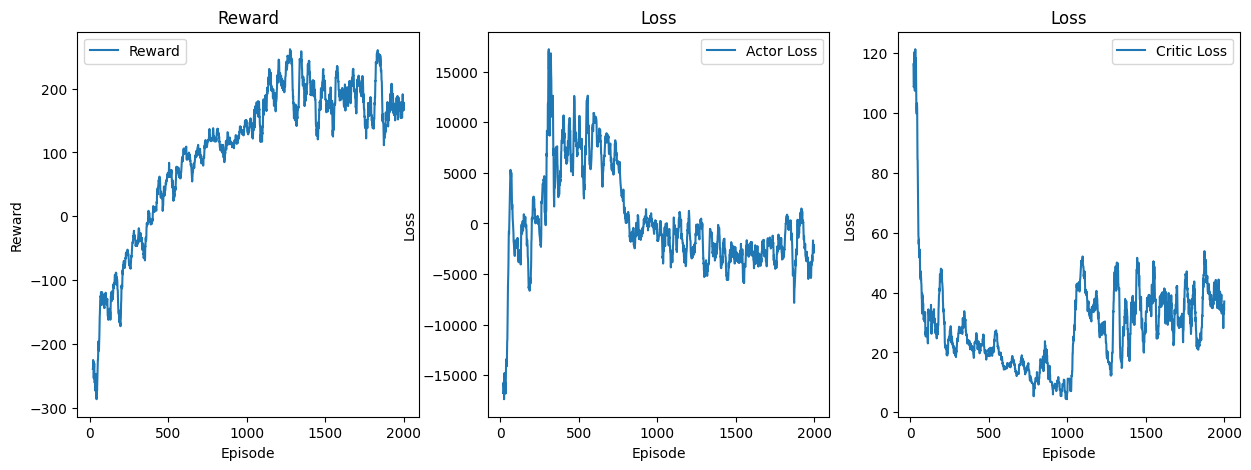

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(rewards.rolling(20).mean(), label="Reward")
ax[0].set_title("Reward")
ax[0].set_xlabel("Episode")
ax[0].set_ylabel("Reward")
ax[0].legend()

ax[1].plot(losses_actor.rolling(20).mean(), label="Actor Loss")
ax[1].set_title("Loss")
ax[1].set_xlabel("Episode")
ax[1].set_ylabel("Loss")
ax[1].legend()

ax[2].plot(losses_critic.rolling(20).mean(), label="Critic Loss")
ax[2].set_title("Loss")
ax[2].set_xlabel("Episode")
ax[2].set_ylabel("Loss")
ax[2].legend()

plt.show()

Generate video of the agent playing the game:

In [7]:
video_dir = Path('./gym_videos')
video_dir.mkdir(parents=True, exist_ok=True)

env = gym.make(env_name, render_mode='rgb_array')
env = gym.wrappers.RecordVideo(
    env,
    video_folder=video_dir,
    name_prefix=env_name,
)

/home/gabrielepintus/ReinforcementLearningProject/venv/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/gabrielepintus/ReinforcementLearningProject/gym_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [8]:
frames, rewards = play(agent, env, 1)

100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


In [9]:
for i, episode_frames in enumerate(frames):
    filename = f"{video_dir}/{env_name}_{i}.mp4"
    clip = ImageSequenceClip(episode_frames, fps=60)
    clip.write_videofile(filename, codec='libx264')
    
    print(f"Episode {i} reward: {rewards[i]:.2f}")    
    
env.close()

MoviePy - Building video gym_videos/LunarLander-v3_0.mp4.
MoviePy - Writing video gym_videos/LunarLander-v3_0.mp4



MoviePy - Done !
MoviePy - video ready gym_videos/LunarLander-v3_0.mp4
Episode 0 reward: 50.13


In [10]:
videos = [ x for x in list(video_dir.glob('*.mp4')) if env_name in x.name]

for video in videos:
    print(video)
    display(Video(video))

gym_videos/LunarLander-v3_0.mp4


gym_videos/LunarLander-v3-episode-0.mp4
